In [2]:
import pandas_datareader.data as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [3]:
start = datetime.datetime(2020,1,1)
end = datetime.datetime.today()
df = pd.DataFrame()                                          #Creates Dataframe
df['2Y'] = pdr.DataReader('DGS2', 'fred', start, end)        #Fetches 2s Data from fred
df['10Y'] = pdr.DataReader('DGS10', 'fred', start, end)      #Fetches 10s Data from fred
df.dropna(inplace = True)
df['Spread'] = df['10Y'] - df['2Y']


In [16]:
#Creating a rolling window, a time period in which we want to compare results 
#Like for a 10 day Moving average, rolling window is 10,so it keeps on calculating 10 day MA for the last 10 days as we move on each day

window = 100
df['Spread_Mean'] = df['Spread'].rolling(window).mean()
df['Spread_Std'] = df['Spread'].rolling(window).std()
df['Z'] = (df['Spread'] - df['Spread_Mean'])/df['Spread_Std']

#First type of signal, where exiting as soon as z_score comes in range [-1,1]
# Signal : Buy Steepner when z score is -1 and buy flattener when z score is 1, mean reversion trades in essense
df['Signal'] = np.where(df['Z'] < -1, 1, np.where(df['Z'] > 1, -1, 0))         #A multi question, where we are saying is z_score < -1, then signal is 1(steepener)
                                                                               #Is z_score is greater than 1, then signal is -1(flattener); otherwise 0(no trade)



#Second type of signal, where exiting only when z_score comes to 0
# Generate “raw” entry signals, leaving NaN when you’d otherwise have 0    
'''
df['RawSignal'] = np.where(df['Z'] < -1,  1,
                    np.where(df['Z'] >  1, -1, 
                            np.nan))
'''



In [20]:
#First type of position sizing
#Scale position size with z-score intensity( large size for large z-score because its a mean reversion strategy, and large outsized move means higher chnces of getting back to mean)
#It is capped at 3 so that we dont crazy size on any trade

df['Position'] = df['Signal']*np.clip(df['Z'].abs(),0,3)  #Taking absolute score of z and capping it to 3, so for z = 1.8, Position is 1.8 for signal -1 (Flattener)
                                                         #For z = -2.5, Position is 2,5 with Signal +1 (Steepener)


#Second type of position sizing and exit
'''
#Forward-fill your entry so you stay in until an explicit exit
df['Position'] = df['RawSignal'].ffill().fillna(0)

#Zero out when you cross the mean
exit_long  = (df['Position'] ==  1) & (df['Z'] >= 0)
exit_short = (df['Position'] == -1) & (df['Z'] <= 0)

df.loc[exit_long | exit_short, 'Position'] = 0
'''

"\n#Forward-fill your entry so you stay in until an explicit exit\ndf['Position'] = df['RawSignal'].ffill().fillna(0)\n\n#Zero out when you cross the mean\nexit_long  = (df['Position'] ==  1) & (df['Z'] >= 0)\nexit_short = (df['Position'] == -1) & (df['Z'] <= 0)\n\ndf.loc[exit_long | exit_short, 'Position'] = 0\n"

In [21]:
#Computing pnl using DV01 
DV01 = 100            # Assume for every 1bps move, 100 USD profit/loss          
df['Spread_Change'] = df['Spread'].diff()

#PnL = Positon on previous day * change in spread * DV01
df['PnL'] = df['Position'].shift(1) * df['Spread_Change'] * DV01
df['CumPnL'] = df['PnL'].cumsum()

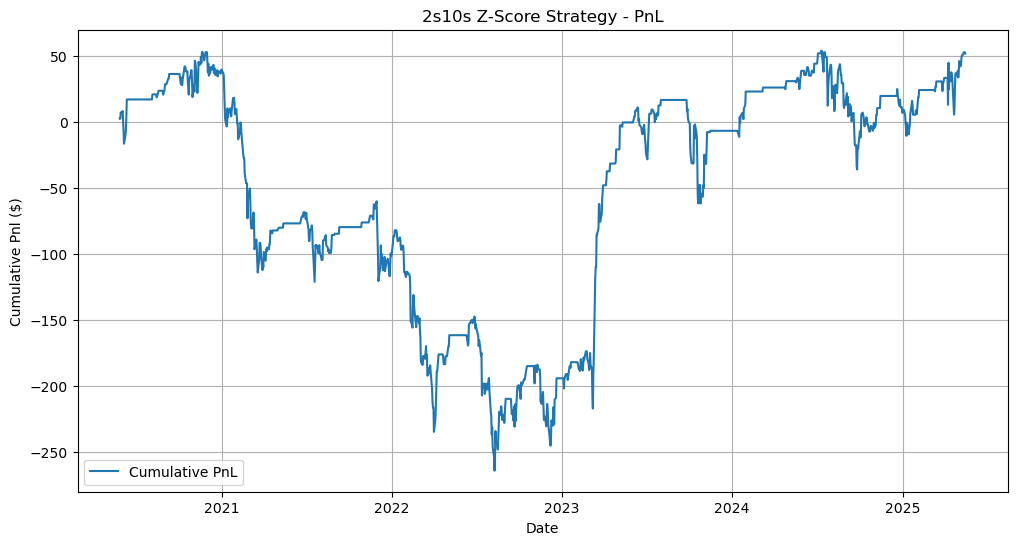

Sharpe Ratio :  0.1
Z-score range: -3.875255528384378 to 3.892388243917893
count    1245.000000
mean        0.103196
std         1.453748
min        -3.875256
25%        -1.097438
50%         0.268834
75%         1.203625
max         3.892388
Name: Z, dtype: float64


In [22]:
plt.figure(figsize = (12,6))
plt.plot(df['CumPnL'],label = 'Cumulative PnL')
plt.title('2s10s Z-Score Strategy - PnL')
plt.xlabel('Date')
plt.ylabel('Cumulative Pnl ($)')
plt.legend()
plt.grid(True)
plt.show()

#Sharpe ratio(assume 252 trading days)
sharpe = df['PnL'].mean()/df['PnL'].std() * np.sqrt(252)       # Daily Sharpe = Average Daily Pnl/Daily PnL Std  and then we annualize it by mutiplying with square root of 252
print("Sharpe Ratio : ", round(sharpe, 2))     #Rounds sharpe ratio to 2 decimal places
#print("Z-score range:", df['Z'].min(), "to", df['Z'].max())
#print(df['Z'].describe())